Tapu Kadastor Analiz Verilerini Kullanma
Bu çalışmada python ile tapu kadastro analiz verilerini nasıl elde edebileceğimizi ve nasıl kullanabileceğimizde bahsedeceğiz.

Tapu Kadastro Genel Müdürlüğü bir bölgede niteliğinden bağımsız alım-satım yoğunluğunu harita üstünden verdiğini biliyor muydunuz?
Bu veriler az kullanılsa da aslında gayrimenkul yatırımınızda doğru yere yatırım yapıp yapmadığınız konusunda size güzel bir bilgi verebilir. Bir bölgenin yıllara göre alım-satım yoğunluğu o bölgede yapacağınız alım kararınız önemli ölçüde etkileyebilir.

Öncelikle https://parselsorgu.tkgm.gov.tr sitesine girerseniz sağ üstte bazı seçenekler göreceksiniz,
burada analiz yazan kısma tıklayıp alt seçenekler alım-satım yoğunluğunu, yılı, il ve ilçeyi seçin ve görüntüleme şeklini de küme
seçip haritada yakınlaşırsanız tam olarak o yıl nerede alım veya satım olduğunu görebilirsiniz.

Şimdi biz bu veriyi python ile nasıl alabilir ve kullanabilirizi anlamaya çalışacağız.


gerekli kütüphaneleri çağırıyoruz.

In [1]:
import pandas as pd
import numpy as np
import requests
import plotly
import plotly.express as px
from itertools import chain

aşağıdaki get isteği attığım url leri biraz yardım ile aldım, şimdi verileri çekmeye başlayalım.
Öncelikle parametre olarak kullanacağım için il listesi çekmeye çalışacağız ve buradaki id leri veri
isteği atarken kullanacağız.

il verileri alırken aşağıdaki endpoint i kullancağız, bu endpoint ile dönen nested yapıdaki json il ismi, 
il id si ve il in polygon geometri sayılarını elde edebiliriz, biz sadece il ve id sini alacağız çünkü
verileri alacağımız endpoint te il ismi değil sitede tanımlanmış id sini kullanacağız

In [2]:
url_city="https://cbsservis.tkgm.gov.tr/megsiswebapi.v3/api//idariYapi/ilListe"
response_city = requests.request("GET", url_city)
city=[i['properties']['text'] for i in response_city.json()['features']]
city=[x.lower() for x in city]
city_id=[i['properties']['id'] for i in response_city.json()['features']]

city_dict = dict(zip(city, city_id))

Aşağıda yazdığımız fonksiyon ile birlikte istediğimiz yıllarda istediğimiz şehir için bu veriyi elde edebileceğiz. 
Veriyi bir for döngüsü içinde her bir yıl için elde ettikten sonra bir listeye ekliyoruz ve bu nested yapıdaki listeyi de
python itertools kütüphanesindeki chain.from_iterables fonkisyionu ile flatten bir yapıya dönüştürüyoruz.

In [3]:
def city_transaction_frequency(city, years):
    city_id=city_dict[city]
    all_transactions=[]
    
    for i in years:
        url = f"https://cbsservis.tkgm.gov.tr/megsiswebapi.v3/api/analiz?AnalizTip=2&Yil={i}&IlId={city_id}"
        response = requests.request("GET", url).json()
      
        for j in response:
            j['Yıl']=i
        all_transactions.append(response)
        
    data = list(chain.from_iterable(all_transactions))
    df=pd.DataFrame(data)
    return df
years=[2017, 2018, 2019]
df=city_transaction_frequency('tunceli', years)

In [4]:
df.sample(5)

parselId      enlem     boylam  sayi   Yıl
11686  33125559  39.395608  39.223894     1  2019
12411  32601325  38.979566  39.581797     1  2019
6205   32050773  39.142000  38.797453     1  2018
158     5150817  39.009334  39.442361     1  2017
10552  32527434  38.856073  39.512166     1  2019

elde ettiğimiz veride parsel, enlem, boylam ve sayı yani adet verisini görebiliyoruz.

Şimdi verimizi görselleştirmeyi deneyelim. Bunun için sağladığı interaktif harita özelliğinden dolayı python plotly kütüphanesini kullanacağız.

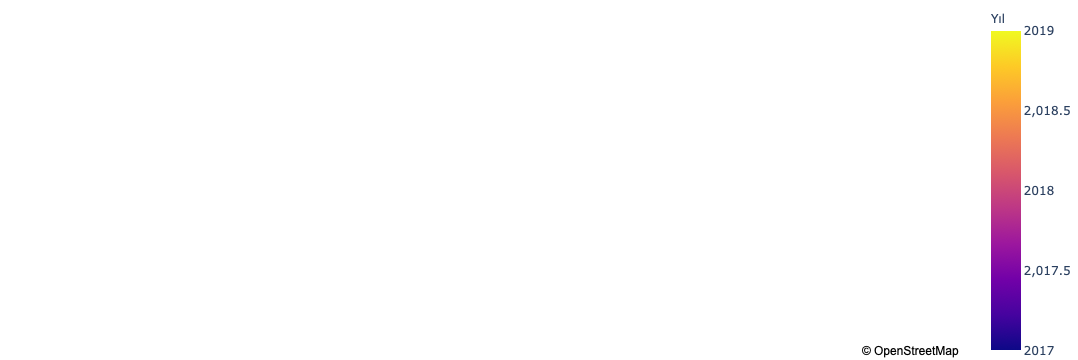

In [5]:
fig = px.scatter_mapbox(df, lat="enlem", lon="boylam", color='Yıl',
                         zoom=7.3, height=300,)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":1,"t":1,"l":1,"b":0})
fig.show()

Peki ya özel bir yerin etrafını keşfetmek isterseniz, o yerin etrafında nasıl bir trend var merak ederseniz?
İşte bunun için de bir çözüm geliştirebiliriz.
haversine iki farklı enlem ve boylam arasındaki mesafeyi hesaplamak için kullanılır biz de ilgilendiğimiz noktanın çevresindeki
trendi bununla bulacağız.

In [6]:
def haversine_vectorize(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

In [7]:
df['destination_lat']=38.90366
df['destination_lon']=39.46212
df['haversine_distance']=haversine_vectorize(df['boylam'],df['enlem'],df['destination_lon'], df['destination_lat'])

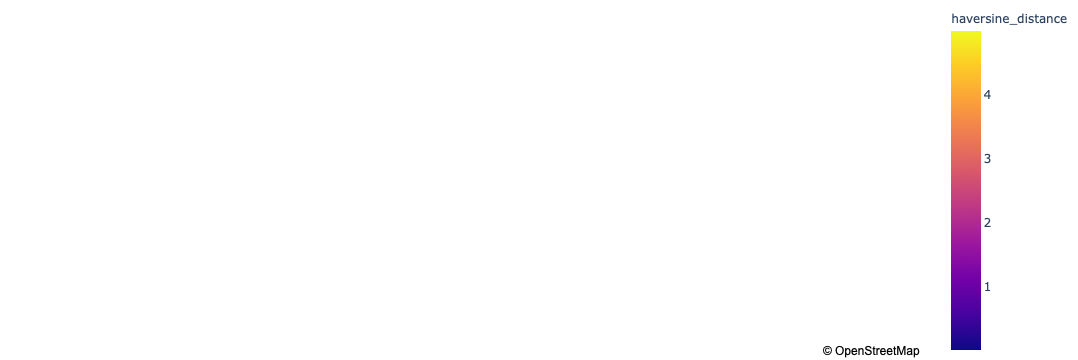

In [8]:
df_5km=df.loc[df['haversine_distance']<=5]
fig = px.scatter_mapbox(df_5km, lat="enlem", lon="boylam", color='haversine_distance',zoom=11.5, height=150)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":1,"t":1,"l":1,"b":0})

fig.show()